In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
from collections import Counter

/work/envs/venv/DL_gpu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pokemon_index_dict = {
    "Bug":0,
    "Dark":1,
    "Dragon":2,
    "Electric":3,
    "Fairy":4,
    "Fighting":5,
    "Fire":6,
    "Flying":7,
    "Ghost":8,
    "Grass":9,
    "Ground":10,
    "Ice":11,
    "Normal":12,
    "Poison":13,
    "Psychic":14,
    "Rock":15,
    "Steel":16,
    "Water":17
}

In [3]:
pokemon_type_list = [
    "Bug",
    "Dark",
    "Dragon",
    "Electric",
    "Fairy",
    "Fighting",
    "Fire",
    "Flying",
    "Ghost",
    "Grass",
    "Ground",
    "Ice",
    "Normal",
    "Poison",
    "Psychic",
    "Rock",
    "Steel",
    "Water"
]

In [4]:
# User input for image resolution
px = 128
img_size = (px,px)

#Batch Size
batch_size = 25

#CPU to run on
current_device='cuda:5'

# Set the path to the dataset directories
image_directory = 'archive/additional_images'
path_to_type_csv = 'archive/pokemon_with_folders.csv'

In [5]:
pokemon_type_dataset = pd.read_csv(path_to_type_csv)

def get_pokemon_types(pokemon_name):
    row = pokemon_type_dataset.loc[pokemon_type_dataset.index[pokemon_type_dataset['Name'].apply(str.lower) == pokemon_name.strip().replace(" ", "").lower()]]
    if len(row) > 0:
        t1 = row["Type"].values
        t2 = row["Other Type"].values
        types = []
        types.append(t1[0])
        if type(t2[0]) != float:
            types.append(t2[0])

        type_binary = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

        for poke_type in types:
            if pokemon_index_dict.__contains__(poke_type):
                type_binary[pokemon_index_dict.get(poke_type)] = 1

        return type_binary
    return None

In [6]:
class ImageFolderWithTypes(Dataset):
    """
    Wraps a torchvision ImageFolder and converts folder-class names to an 18-d
    multi-hot label using the existing `get_pokemon_types(name)` helper.
    - imagefolder: an instance of torchvision.datasets.ImageFolder
    - get_type_fn: function that accepts a pokemon name and returns a list/array of 18 ints or None
    - normalize_name_fn: function to normalize folder names (default replaces '_' with ' ')
    """

    def __init__(self, imagefolder: ImageFolder, get_type_fn=get_pokemon_types, normalize_name_fn=lambda s: s.replace('_', ' ')):
        self.imagefolder = imagefolder
        self.get_type_fn = get_type_fn
        self.normalize = normalize_name_fn

        # Build index of valid sample indices and labels
        self.indices = []
        self.labels = []  # list of lists (multi-hot)
        for i, (img_path, cls_idx) in enumerate(self.imagefolder.samples):
            cls_name = self.imagefolder.classes[cls_idx]
            normalized = self.normalize(cls_name)
            types = self.get_type_fn(normalized)
            if types is None:
                # skip samples we can't map; you can log them for inspection
                # print(f"Skipping unmapped class: {cls_name}")
                continue
            self.indices.append(i)
            self.labels.append(np.array(types, dtype=np.float32))

        # compute class positive counts (useful for pos_weight)
        self.labels_np = np.vstack(self.labels) if len(self.labels) > 0 else np.zeros((0, len(pokemon_type_list)), dtype=np.float32)
        self.pos_counts = self.labels_np.sum(axis=0) if self.labels_np.size else np.zeros(len(pokemon_type_list))
        self.neg_counts = len(self.labels) - self.pos_counts

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        orig_idx = self.indices[idx]
        image, _ = self.imagefolder[orig_idx]  # will apply transforms
        label = torch.from_numpy(self.labels[idx])  # float tensor for BCEWithLogitsLoss
        return image, label

    def get_pos_weight_tensor(self, device=None):
        # Avoid division by zero
        eps = 1e-6
        pos = self.pos_counts
        neg = self.neg_counts
        pos_weight = (neg + eps) / (pos + eps)
        t = torch.tensor(pos_weight, dtype=torch.float32)
        if device:
            return t.to(device)
        return t

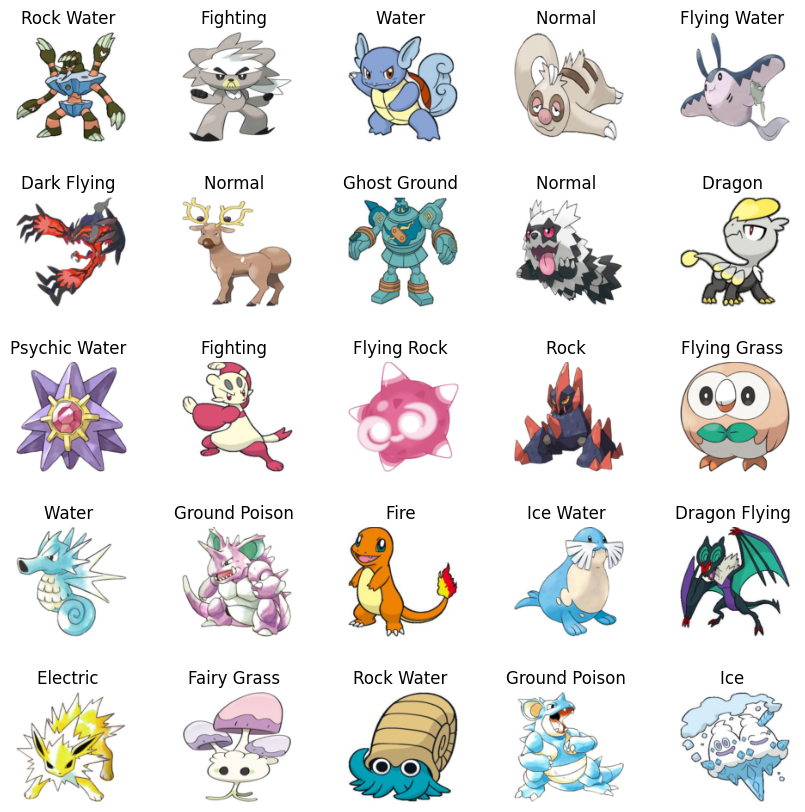

In [7]:
# Visualize data 
# Define function that plots multiple images in an array of images
def PlotImages(ix_start,num_img,rows,cols,images,labels,color=True):
    plt.figure(figsize=(10,10))
    plt.subplots_adjust(wspace=0.5,hspace=0.5)
    for i in range(num_img):
        plt.subplot(rows,cols,i+1)
        plt.axis('off')
        if color:
            plt.imshow(images.permute(0, 2, 3, 1)[ix_start+i])
        else: 
            plt.imshow(np.squeeze(images[ix_start+i]),cmap='Greys')
        pokemon_types = labels[ix_start+i]
        
        title = ""
        for index in range(0, 18):
            if pokemon_types[index] == 1:
                title = title + pokemon_type_list[index] + " "

        plt.title(title)

# Image loader and scaler for image exploration
explorer_batch_size = 25
load_image = transforms.Compose([
    transforms.Resize((px, px)),
    transforms.ToTensor()
])
raw_folder = ImageFolder(root=image_directory, transform=load_image)
dataset = ImageFolderWithTypes(raw_folder)
dataloader = DataLoader(dataset, batch_size=explorer_batch_size, shuffle=True, num_workers=47)
data_iter = iter(dataloader)

images, labels = next(data_iter)
next(data_iter)
PlotImages(0,explorer_batch_size,5,5,images,labels,color=True)

In [8]:
# =============================================================================
# Function to create weighted sampler for handling class imbalance
# =============================================================================
def create_weighted_sampler(dataset):
    """
    Create a WeightedRandomSampler for a multilabel dataset.

    The dataset is expected to return (image, label) where label is a 1-D
    binary array/tensor of length C (multi-hot). We compute per-class
    inverse-frequency weights and give each sample a weight equal to the
    sum of weights of the classes present in that sample (plus a small
    constant to avoid zero weight).
    """
    # Collect labels as numpy arrays (N x C)
    labels = []
    for i in range(len(dataset)):
        lab = dataset[i][1]
        if isinstance(lab, torch.Tensor):
            lab = lab.detach().cpu().numpy()
        labels.append(np.array(lab, dtype=np.float32))
    if len(labels) == 0:
        raise ValueError("Dataset contains no mapped samples")

    labels_np = np.vstack(labels)  # shape (N, C)
    N, C = labels_np.shape

    # Per-class positive counts
    pos_counts = labels_np.sum(axis=0)  # length C
    # Avoid division by zero
    eps = 1e-6
    # Inverse frequency weight for each class: more weight for rarer classes
    class_weights = (N - pos_counts + eps) / (pos_counts + eps)

    # Per-sample weight: sum of the class weights for classes present in sample
    sample_weights = (labels_np * class_weights).sum(axis=1) + 1e-3

    # Normalize optional (keep relative weights)
    sample_weights = sample_weights / (sample_weights.sum() / N)

    sampler = WeightedRandomSampler(weights=sample_weights.tolist(), num_samples=N, replacement=True)
    return sampler

In [9]:
# =============================================================================
# Function to calculate per-class pos_weight for BCEWithLogitsLoss (multilabel)
# =============================================================================
def calculate_pos_weight_from_multilabel(labels_list):
    """
    Given a list (or array) of multi-hot label vectors (N x C), compute the
    pos_weight tensor recommended for torch.nn.BCEWithLogitsLoss.

    labels_list: iterable of length-N where each element is length-C (list/np/torch)
    returns: torch.FloatTensor of length C usable as pos_weight
    """
    if len(labels_list) == 0:
        return torch.ones(len(pokemon_type_list), dtype=torch.float32)

    # Ensure a numpy array (N, C)
    if isinstance(labels_list, np.ndarray):
        labels_np = labels_list.astype(np.float32)
    else:
        labels_np = np.vstack([np.array(x, dtype=np.float32) for x in labels_list])

    N, C = labels_np.shape
    pos_counts = labels_np.sum(axis=0)
    neg_counts = N - pos_counts

    # pos_weight = neg/pos for each class; avoid divide-by-zero
    eps = 1e-6
    pos_weight = (neg_counts + eps) / (pos_counts + eps)

    # Convert to torch tensor
    return torch.tensor(pos_weight, dtype=torch.float32)


In [10]:
# =============================================================================
# IMPROVED: Train full network end-to-end instead of just features
# =============================================================================

# Impot necessary libraries
from time import time
from sklearn.model_selection import train_test_split

# Load full dataset and split into train/test
raw_folder = ImageFolder(root=image_directory)
full_dataset = ImageFolderWithTypes(raw_folder)
all_labels = [full_dataset[i][1] for i in range(len(full_dataset))]

# Split indices with stratification to maintain class distribution
train_indices, test_indices = train_test_split(
    range(len(full_dataset)), 
    test_size=0.2, 
    random_state=0
)

print(f'Train size: {len(train_indices)}, Test size: {len(test_indices)}')


Train size: 2000, Test size: 501


In [11]:

# This class encapsulates all the data loading and preparation steps.
class PokemonDataModule(pl.LightningDataModule):
    def __init__(self, dataset, train_indices, test_indices, batch_size=64):
        super().__init__()
        self.dataset = dataset
        self.train_indices = train_indices
        self.test_indices = test_indices
        self.batch_size = batch_size
        
        # Define transforms with augmentation for training
        self.train_transform = transforms.Compose([
            transforms.Resize((px + 20, px + 20)),
            transforms.RandomCrop((px, px)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.test_transform = transforms.Compose([
            transforms.Resize((px, px)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
    def setup(self, stage=None):
        # Create train and test datasets with appropriate transforms
        raw_folder1 = ImageFolder(root=image_directory, transform=self.train_transform)
        self.train_dataset = ImageFolderWithTypes(raw_folder1)

        raw_folder2 = ImageFolder(root=image_directory, transform=self.test_transform)
        self.test_dataset = ImageFolderWithTypes(raw_folder2)
        
        # Use subset of indices for train/test split
        self.train_subset = torch.utils.data.Subset(self.train_dataset, self.train_indices)
        self.test_subset = torch.utils.data.Subset(self.test_dataset, self.test_indices)
        
    def train_dataloader(self):
        # Create a multilabel-aware weighted sampler for the training subset
        # The helper `create_weighted_sampler` expects a dataset returning
        # (image, multi_hot_label) and will compute per-sample weights.
        sampler = create_weighted_sampler(self.train_subset)
        return DataLoader(self.train_subset, batch_size=self.batch_size, sampler=sampler, num_workers=47)
    
    def test_dataloader(self):
        return DataLoader(self.test_subset, batch_size=self.batch_size, shuffle=False, num_workers=47)



In [ ]:
# =============================================================================
# IMPROVED MODEL: Fine-tune ResNet50 with progressive unfreezing
# =============================================================================
class ResNetPokemonClassifier(pl.LightningModule):
    def __init__(self, num_classes=len(pokemon_type_list), learning_rate=0.001):
        super().__init__()
        self.learning_rate = learning_rate
        
        # Load pretrained ResNet50 (could also use 18/34/101/152)
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        # Progressive layer unfreezing (earlier layers remain frozen longer)
        # Freeze all backbone layers initially
        for param in resnet.parameters():
            param.requires_grad = False
            
        # Unfreeze final blocks selectively
        for name, child in resnet.named_children():
            if name == 'layer4':  # Unfreeze last block immediately
                for param in child.parameters():
                    param.requires_grad = True
            elif name == 'layer3':  # Partial unfreeze of block 3
                for i, module in enumerate(child):
                    if i > len(child) // 2:  # Unfreeze latter half
                        for param in module.parameters():
                            param.requires_grad = True
        
        # Remove the final classification layer
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        
        # Custom classifier head for Pokemon types
        self.classifier = nn.Sequential(
            nn.Flatten(),  # ResNet outputs (batch_size, 2048, 1, 1)
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )
        
        # Calculate per-class pos_weight for multilabel BCEWithLogitsLoss
        train_labels = [all_labels[i] for i in train_indices]
        pos_weight = calculate_pos_weight_from_multilabel(train_labels)
        # Register pos_weight as buffer so it moves with the model to the device
        self.register_buffer('pos_weight', pos_weight)
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        
        # Track best accuracy
        self.best_acc = 0
        
    def forward(self, x):
        x = self.features(x)  # ResNet features -> (batch_size, 2048, 1, 1)
        x = self.classifier(x)  # includes flattening and FC layers
        return x
    
    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        # labels are expected to be multi-hot float tensors for BCEWithLogitsLoss
        labels = labels.type_as(outputs)
        loss = self.criterion(outputs, labels)

        # Multilabel micro accuracy (fraction of correctly predicted bits)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        acc = (preds == labels).float().mean()
        
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        labels = labels.type_as(outputs)
        loss = self.criterion(outputs, labels)

        preds = (torch.sigmoid(outputs) > 0.5).float()
        acc = (preds == labels).float().mean()

        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)

        return {'test_loss': loss, 'test_acc': acc}
    
    def configure_optimizers(self):
        # Different learning rates for features vs classifier
        optimizer = torch.optim.Adam([
            {'params': self.features.parameters(), 'lr': self.learning_rate * 0.1},
            {'params': self.classifier.parameters(), 'lr': self.learning_rate}
        ], weight_decay=1e-4)
        
        # Learning rate scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=5
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'train_acc',
                'interval': 'epoch',
                'frequency': 1,
                'reduce_on_plateau': True,
                'strict': True,
                'verbose': True,
                }
            }

In [13]:
# Instantiate the DataModule
pokemon_data = PokemonDataModule(full_dataset, train_indices, test_indices, batch_size=batch_size)
pokemon_data.setup()

# Calculate and print class weights
train_labels = [all_labels[i] for i in train_indices]
pos_weight = calculate_pos_weight_from_multilabel(train_labels)
print("\nPer-class pos_weight for BCEWithLogitsLoss:")
for i, weight in enumerate(pos_weight.tolist()):
    print(f"  {pokemon_type_list[i]}: {weight:.4f}")

# Instantiate the ResNet model (reduced learning rate since ResNet is deeper)
model = ResNetPokemonClassifier(learning_rate=0.0005)

# The Trainer with callbacks for better monitoring
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback = ModelCheckpoint(
    monitor='train_acc',
    dirpath='checkpoints/',
    filename='pokemon-resnet-{epoch:02d}-{train_acc:.2f}',
    save_top_k=3,
    mode='max'
)

early_stop_callback = EarlyStopping(
    monitor='train_acc',
    patience=15,
    mode='max',
    verbose=True
)

trainer = pl.Trainer(
    max_epochs=10,
    accelerator='gpu',
    devices=[4],
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=10
)

# Start the training process
time_start = time()
trainer.fit(model, datamodule=pokemon_data)
time_stop = time()

print(f"\nElapsed training time: {round(time_stop - time_start, 1)} sec.")
print(f"Best training accuracy achieved: {model.best_acc:.2f}%")

# Evaluate the model on the test dataset
test_results = trainer.test(model, datamodule=pokemon_data)
print(f"\nFinal test results: {test_results}")

/tmp/ipykernel_1732915/2804406287.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  labels_np = np.vstack([np.array(x, dtype=np.float32) for x in labels_list])



Per-class pos_weight for BCEWithLogitsLoss:
  Bug: 9.8696
  Dark: 17.0180
  Dragon: 15.5289
  Electric: 15.2602
  Fairy: 15.5289
  Fighting: 15.0000
  Fire: 11.1212
  Flying: 6.9365
  Ghost: 17.6916
  Grass: 7.9686
  Ground: 11.6582
  Ice: 25.6667
  Normal: 6.4627
  Poison: 10.4286
  Psychic: 8.6618
  Rock: 13.2857
  Steel: 16.5439
  Water: 5.1538


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/work/envs/venv/DL_gpu/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /work/cssema416/202610/08/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/work/envs/venv/DL_gpu/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /work/cssema416/202610/08/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/work/envs/venv/DL_gpu/lib/python3.11/site-packages/pytorch_lightning/core/optimizer.py:259: Found unsupported keys in the lr scheduler dict: {'verbose'}. HINT: remove them from the output of `configure_optimizers`.

  | Name       | Type              | Params | Mode 
------------------------------------------------

Epoch 0: 100%|██████████| 80/80 [00:05<00:00, 15.96it/s, v_num=36, train_loss=1.330, train_acc=0.0956]

Metric train_acc improved. New best score: 0.096


Epoch 1: 100%|██████████| 80/80 [00:06<00:00, 11.72it/s, v_num=36, train_loss=1.270, train_acc=0.113] 

Metric train_acc improved by 0.018 >= min_delta = 0.0. New best score: 0.113


Epoch 2: 100%|██████████| 80/80 [00:06<00:00, 11.84it/s, v_num=36, train_loss=1.330, train_acc=0.122] 

Metric train_acc improved by 0.009 >= min_delta = 0.0. New best score: 0.122


Epoch 3: 100%|██████████| 80/80 [00:06<00:00, 12.00it/s, v_num=36, train_loss=1.210, train_acc=0.151]

Metric train_acc improved by 0.029 >= min_delta = 0.0. New best score: 0.151


Epoch 4: 100%|██████████| 80/80 [00:06<00:00, 12.08it/s, v_num=36, train_loss=1.180, train_acc=0.160]

Metric train_acc improved by 0.009 >= min_delta = 0.0. New best score: 0.160


Epoch 6: 100%|██████████| 80/80 [00:06<00:00, 12.17it/s, v_num=36, train_loss=1.080, train_acc=0.180]

Metric train_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.180


Epoch 7: 100%|██████████| 80/80 [00:06<00:00, 11.93it/s, v_num=36, train_loss=1.140, train_acc=0.216]

Metric train_acc improved by 0.036 >= min_delta = 0.0. New best score: 0.216


Epoch 8: 100%|██████████| 80/80 [00:06<00:00, 12.20it/s, v_num=36, train_loss=1.140, train_acc=0.240]

Metric train_acc improved by 0.024 >= min_delta = 0.0. New best score: 0.240


Epoch 9: 100%|██████████| 80/80 [00:06<00:00, 11.99it/s, v_num=36, train_loss=1.100, train_acc=0.164]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 80/80 [00:06<00:00, 11.98it/s, v_num=36, train_loss=1.100, train_acc=0.164]


Elapsed training time: 110.6 sec.
Best training accuracy achieved: 0.00%

Elapsed training time: 110.6 sec.
Best training accuracy achieved: 0.00%


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|██████████| 21/21 [00:00<00:00, 42.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.18108229339122772
        test_loss           1.1290233135223389
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.18108229339122772
        test_loss           1.1290233135223389
──────────────────────────────────────────────

In [ ]:
torch.save(resnet_model.state_dict(), "resnet_pokemon.pt")